In [ ]:
print("hello world")

hello world


In [1]:
import numpy as np
import os

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import time

## Reading


In [3]:
def read_pbm(filename):
    with open(filename, 'r', encoding = 'utf-8') as f:

        # Read the header
        magic_number = f.readline().strip()
        if magic_number != 'P1':
            raise ValueError("File is not a valid ASCII PBM (P1) file.")
        
        # Skip comments
        line = f.readline()
        while line.startswith('#'):
            line = f.readline()
        
        # Read dimensions
        width, height = map(int, line.split())
        
        # Read pixel data
        pixels = []
        for line in f:
            pixels.extend(line.split())
        
    # Convert to numpy array and reshape
    image = np.array(pixels, dtype=int).reshape((height, width))
    return image

In [4]:
def write_pbm(image, filename):
    with open(filename, 'w') as f:
        f.write("P1\n")
        f.write("16 16\n")
        for row in image:
            for el in row:
                if el == 0:
                    f.write("0 ")
                else:
                    f.write("1 ")
            f.write("\n")



In [5]:
pbm_files = [f for f in os.listdir("pbm_files")]

In [6]:
pbm_files

['image_1.pbm', 'image_2.pbm', 'image_3.pbm', 'image_4.pbm']

In [7]:
train_images = []
for file in pbm_files:
    train_images.append(read_pbm("pbm_files/" + file))


In [8]:
train_images

[array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]),
 array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 

In [9]:
write_pbm(train_images[0], "test.pbm")

## Display Function

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def display_image(image):
    # Reshape to 16x16 for visualization
    image = image.reshape(16, 16)

    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()


## Training


In [11]:
weights = np.zeros((256, 256))

for img in train_images:
    img_vector = img.flatten() * 2 - 1 #to convert 0, 1 to -1, 1
    weights += np.outer(img_vector, img_vector) # same as img_vector @ img_vector.T but better data form

for i in range(256):
    weights[i][i] = 0

weights = weights/len(train_images) #dividing by number of training images


## Memory Corruption Functions

In [12]:
def random_flip(image, p):
    corrupted = image.copy()
    flip_bool = np.random.rand(16, 16) < p # bool 16x16 to figure which ones to flip

    corrupted[flip_bool] = 1 - corrupted[flip_bool]
    return corrupted
    

In [13]:
def corrupt_crop(image, box_size):
    corrupted = np.zeros((16,16))
    start = (16 - box_size) // 2
    corrupted[start:start+box_size, start:start+box_size] = image[start:start+box_size, start:start+box_size]
    return corrupted

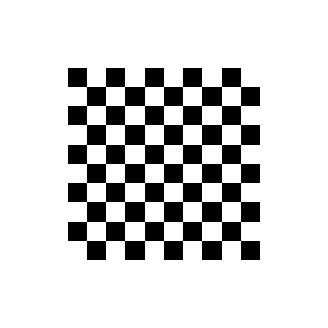

In [14]:
display_image(corrupt_crop(train_images[1], 10))

## Update Functions

In [15]:
def sync_update(image): # returns in image back -1 and 1 # returns final state and number of iterations
    theta = 0 #threshold
    state = image.flatten() * 2 - 1 #to convert to 1 and -1
    iterations = 100
    for i in range(iterations):
        new_state = np.where(weights @ state >= theta, 1, -1) #update function

        if np.array_equal(new_state, state): # if function to break when we reach convergence
            break
        state = new_state 
        display_image(state)
        
    print("Number of iterations it took to converge: ", i)
    return state.reshape(16, 16), i


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display

def async_update(image, iterations=1000): # returns final state and number of iterations
    theta = 0
    state = image.flatten() * 2 - 1  # Convert to {-1, 1}

    plt.ion()
    fig, ax = plt.subplots()

    for its in range(iterations):
        i = np.random.randint(256)  # Random neuron index
        sum_input = np.dot(weights[i], state)
        
        if sum_input >= theta:
            state[i] = 1
        else:
            state[i] = -1

        # Display the current state
        ax.clear()
        ax.set_axis_off()
        ax.imshow((state.reshape(16, 16) + 1) // 2, cmap='binary')
        display(fig)
        clear_output(wait=True)
        time.sleep(0.005)
    
    print("Number of iterations it took to converge: ", its)

    return (state.reshape(16, 16) + 1) // 2, its  # Convert back to 0 and 1


## Running the Algorithm

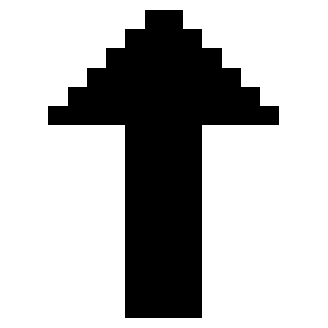

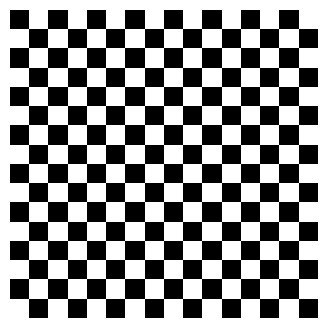

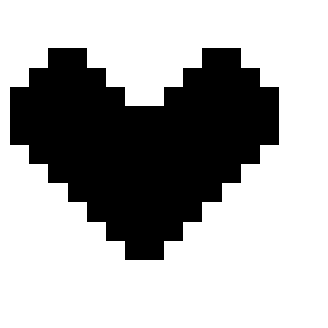

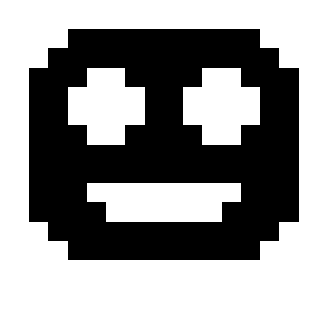

In [17]:
for img in train_images:
    display_image(img)

In [18]:
weights

array([[0. , 0.5, 1. , ..., 1. , 0.5, 1. ],
       [0.5, 0. , 0.5, ..., 0.5, 1. , 0.5],
       [1. , 0.5, 0. , ..., 1. , 0.5, 1. ],
       ...,
       [1. , 0.5, 1. , ..., 0. , 0.5, 1. ],
       [0.5, 1. , 0.5, ..., 0.5, 0. , 0.5],
       [1. , 0.5, 1. , ..., 1. , 0.5, 0. ]], shape=(256, 256))

In [19]:
corrupted = random_flip(train_images[1], 0.35)

In [20]:
display(corrupted)

array([[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]])

In [21]:
#async_update(corrupted)

# Task 1:

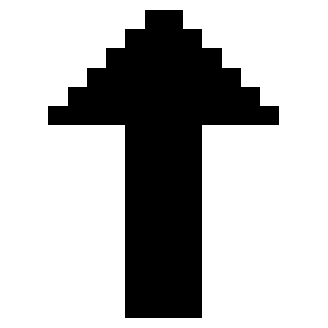

In [22]:
image = train_images[0]
display_image(image)

In [23]:
random_flipped_image = random_flip(image, 0.3)

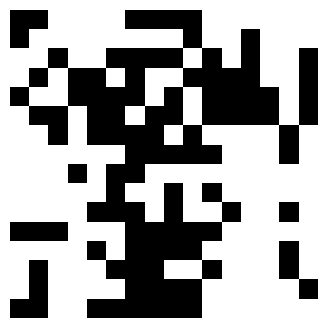

In [24]:
display_image(random_flipped_image)

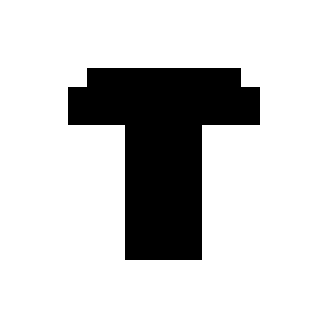

In [25]:
cropped_image = corrupt_crop(image, 10)
display_image(cropped_image)

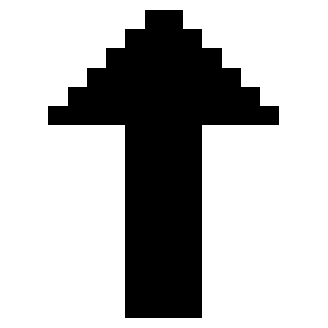

Number of iterations it took to converge:  1


In [26]:
a, b = sync_update(random_flipped_image)

Number of iterations it took to converge:  999


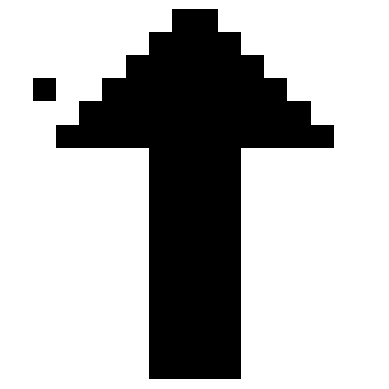

In [28]:
a = async_update(random_flipped_image)